In [1]:
# encoding:utf-8
import copy
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
import time
import sys,os
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler

import model
import preprocessing

In [2]:
word2vec = preprocessing.Word2vec()

In [3]:
#data loader
class Twitter_data(Dataset):
    def __init__(self,path,transform=None):
        self.path = path
        self.transform = transform
        self.df = pd.read_csv(path,dtype = 'object')
        self.mt = preprocessing.Mecab_neologd()
        # self.word2vec = preprocessing.Word2vec()

    def __getitem__(self,index):
        row = self.df.iloc[index]
        text = row["text"]
        label_1 = row["reply_retweet_count"]
        label_2 = row["reply_favorited_count"]

        inputs = np.array([])
        text_normalized = self.mt.normalize_neologd(text) #正規化
        wakati_texts = self.mt.m.parse(text_normalized).split(" ") #単語ごとにパーサー
        
#         print(wakati_texts)
#         print("word_len:",len(wakati_texts))
        for word in wakati_texts:
            
            try:
                vec = word2vec.transform(word) #ベクトル変換
                vec = np.reshape(vec,(1,1,-1))
                if len(inputs)==0:
                    inputs = vec
                else:
                    inputs = np.concatenate([inputs,vec])

            except:
                # print("Unexpected error:", sys.exc_info()[0])
                pass
#         print(inputs.size)
        inputs_ = torch.from_numpy(inputs)
#         print(inputs.shape)
        # print(inputs_)

        return [inputs,label_1,label_2]

    def __len__(self):
        row_nums,columns_num = self.df.shape
        return row_nums

In [17]:
full_dataset = Twitter_data(path="data/2019_04_04/result.csv",
                            transform = transforms.Compose([
                            transforms.ToTensor()
                            ]))



num_train = len(full_dataset)
indicies = list(range(num_train))
split = int(np.floor(0.8*num_train))
#shuffle
random_seed = 1
np.random.seed(random_seed)
np.random.shuffle(indicies)

train_idx,test_idx = indicies[:split],indicies[split:]
train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(test_idx)

train_loader = torch.utils.data.DataLoader(full_dataset,
                                          batch_size=1,
                                          sampler=train_sampler)

test_loader = torch.utils.data.DataLoader(full_dataset,
                                          batch_size=1,
                                          sampler=test_sampler)


In [36]:
class Trainer():
    def __init__(self):
        self.model = model.LSTM(100,128,2)
        self.criterion = nn.MSELoss()
        self.epoch_num = 0
        self.train_data_num = 0
        self.test_data_num = 0
    
    def epoch_run(self,train=False):
        if train:
            self.epoch_num += 1
            data_loader = train_loader
        else:
            data_loader = test_loader
        losses = []
        data_count,correct = 0,0
        for datas in data_loader:
            inputs_,rt_num,fav_num = datas
            rt_num = int(rt_num[0])
            fav_num = int(fav_num[0])
            if inputs_.dim()>2:
                inputs_ = inputs_[0,:,:,:]
                data_count += 1

                output = self.model(inputs_)
                predict = torch.argmax(output)
        #         print(output)
                reward = torch.zeros(2)
                if fav_num+rt_num>0:
                    label = 1  
                else:
                    label = 0
                reward[label] = 1
                if predict == label:
                    correct += 1
                loss = self.criterion(output,reward.float())
                if train:
                    loss.backward()
                    self.model.optimizer.step()

                losses.append(loss.item())
        if train:
            model_path = "model/LSTMver1/epoch"+"{0:04d}".format(self.epoch_num)
            torch.save(self.model.state_dict(),model_path)
        return data_count,losses
    

In [37]:
trainer = Trainer()
train_losses = []
test_losses = []
ave_train_losses = []
ave_test_losses = []

In [38]:
EpochNum = 10

for epoch in range(EpochNum): 
    begin_time = time.time()
    #train
    data_count,losses = trainer.epoch_run(train=True)
#     print(losses)
    train_losses = train_losses+losses
    ave_train_losses.append(sum(losses)/len(losses))
    
    #test
    data_count,losses = trainer.epoch_run(train=False)
    test_losses = test_losses + losses
    ave_test_losses.append(sum(losses)/len(losses))
    runtime = time.time()-begin_time
    print("epoch:{0:03.0f}time:{1:0.2f}".format(trainer.epoch_num,runtime))

epoch:001time:7.57
epoch:002time:6.69
epoch:003time:6.66
epoch:004time:6.51
epoch:005time:6.53
epoch:006time:6.51
epoch:007time:6.59
epoch:008time:6.61
epoch:009time:6.76
epoch:010time:7.01


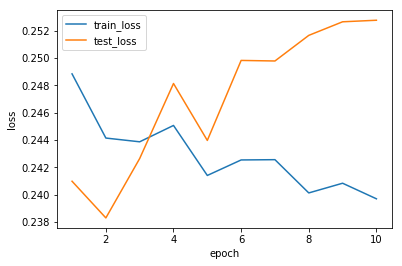

In [39]:
fig = plt.figure()
ax = fig.add_subplot(111)
# x = [i for i in range(data_count)]

# ave_losses = []
# losss = 0
# for ix in range(data_count):
#     losss += losses[ix]
#     if (ix+1)%10==0:
#         ave_losses.append(losss/10)
#         losss = 0
    
x = [1+i for i in range(len(ave_test_losses))]
y1 = ave_train_losses
y2 = ave_test_losses

ax.plot(x,y1,label="train_loss")
ax.plot(x,y2,label="test_loss")

ax.set_xlabel("epoch")
ax.set_ylabel("loss")
# ax.plot(x,y2,label="correct ratio")

ax.legend()
plt.show()

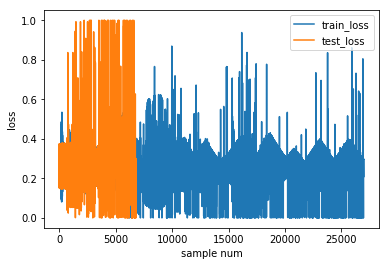

In [47]:
fig = plt.figure()
ax1 = fig.add_subplot(111)


x = [1+i for i in range(len(train_losses))]
y1 = train_losses
x2 = [1+i for i in range(len(test_losses))]
y2 = test_losses

ax1.plot(x,y1,label="train_loss")
ax1.set_xlabel("sample num")
ax1.set_ylabel("loss")

ax2 = fig.add_subplot(111)
ax2.plot(x2,y2,label="test_loss")
ax2.set_xlabel("sample num")
ax2.set_ylabel("loss")
ax2.legend()
plt.show()
# ax.plot(x,y2,label="correct ratio")

